In [75]:
#from google.colab import drive
#drive.mount('/content/drive')

In [76]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 복습 코드

# 라이브러리

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 파이썬 시계열 기본 라이브러리
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [78]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/iM_alphaco/시계열 강의안(통계, ML, DL)/data/'

df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

# 시계열의 가장 기본적인 포멧

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [80]:
df.tail()

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


# 데이터 시각화

In [81]:
df['year'] = pd.DatetimeIndex(df['date']).year
df.head()

,date,data,year
0,1960-01-01,0.71,1960
1,1960-04-01,0.63,1960
2,1960-07-02,0.85,1960
3,1960-10-01,0.44,1960
4,1961-01-01,0.61,1961


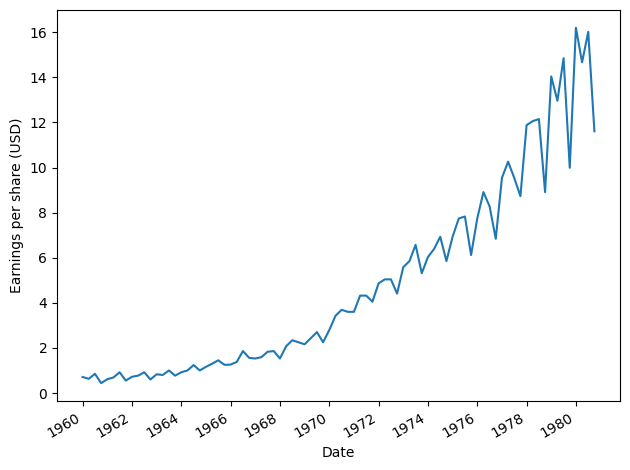

In [82]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 시계열 분해 및 시각화
- 메서드 공식 DOCS에서 참고하기

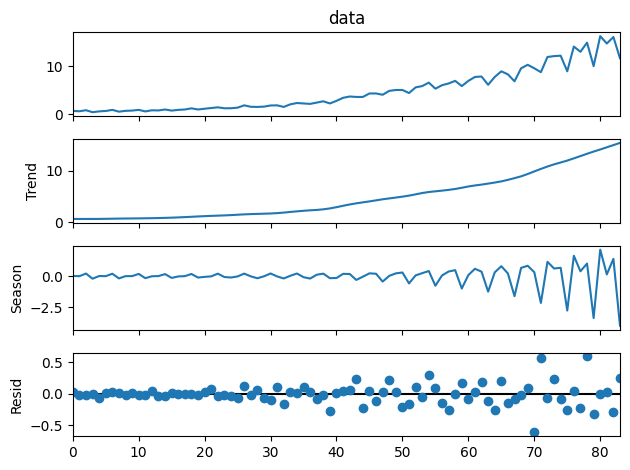

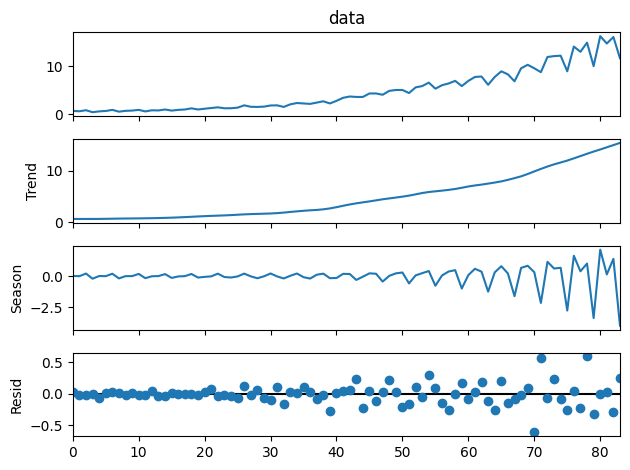

In [83]:
res = STL(df.data, period = 4).fit()
res.plot()

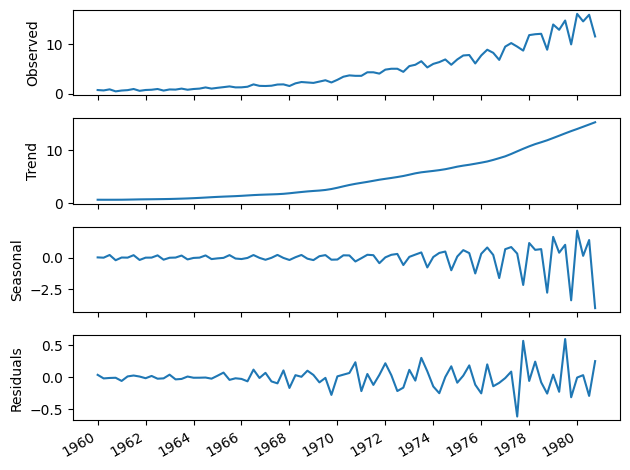

In [84]:
advanced_decomposition = STL(df.data, period=4).fit()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# 데이터 복원
- 원래상태로 복구

In [85]:
df = df.drop('year', axis = 1)
df

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


## 베이스라인 모델 설계
- ML과는 다른 모델 설계
- 훈련데이터 : 1960년 ~ 1979년
- 예측데이터 : 1980년

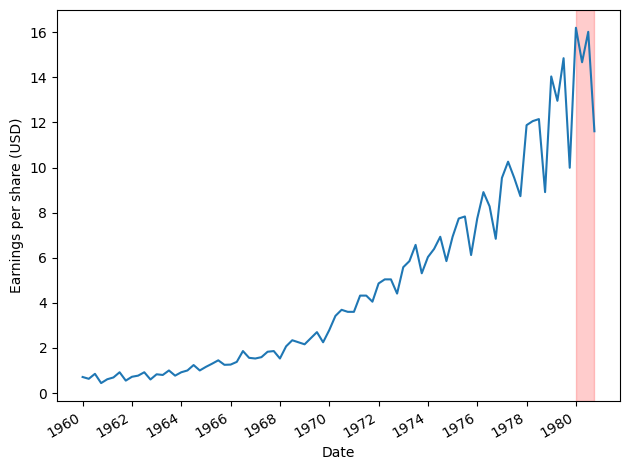

In [86]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='red', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 평가 지표 만들기
- MAPE함수 만들기

In [87]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## 데이터 셋 분리
- 분기 기준이므로 마지막 4분기만 테스트 데이터로 잘라내면 된다.

In [88]:
train = df[:-4]
test = df[-4:]

In [89]:
test

,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [90]:
train.head(4)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44


## 모델 학습

- 되게 단순해보이지만 이게 베이스라인 모델이다!

In [91]:
historical_mean = np.mean(train['data'])
historical_mean

4.308499987499999

In [92]:
test.loc[:, 'preds_mean'] = historical_mean
test

<ipython-input-92-c7252d6895d3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'preds_mean'] = historical_mean


,date,data,preds_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


## 모델 평가

In [93]:
mape_hist_mean = mape(test['data'], test['preds_mean'])
mape_hist_mean

70.00752579965119

In [94]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(test['data'], test['preds_mean']) * 100

70.00752579965119

## 모델 평가 - 두 번째 모델

In [95]:
train[-4:]

,date,data
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85
79,1979-10-01,9.99


In [96]:
second_mean = np.mean(train['data'][-4:])
second_mean

12.96

In [97]:
test.loc[:, '1979preds'] = second_mean
mape_last_year = mean_absolute_percentage_error(test['data'], test['1979preds']) * 100
mape_last_year

<ipython-input-97-218774e031c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, '1979preds'] = second_mean


15.5963680725103

# 24-11-22 시작
- 이전까진 복습코드

In [98]:
test

,date,data,preds_mean,1979preds
80,1980-01-01,16.20,4.3085,12.96
81,1980-04-01,14.67,4.3085,12.96
82,1980-07-02,16.02,4.3085,12.96
83,1980-10-01,11.61,4.3085,12.96


<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:29: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
<ipython-input-99-3c23ddabdd65>:30: UserWarning: Gl

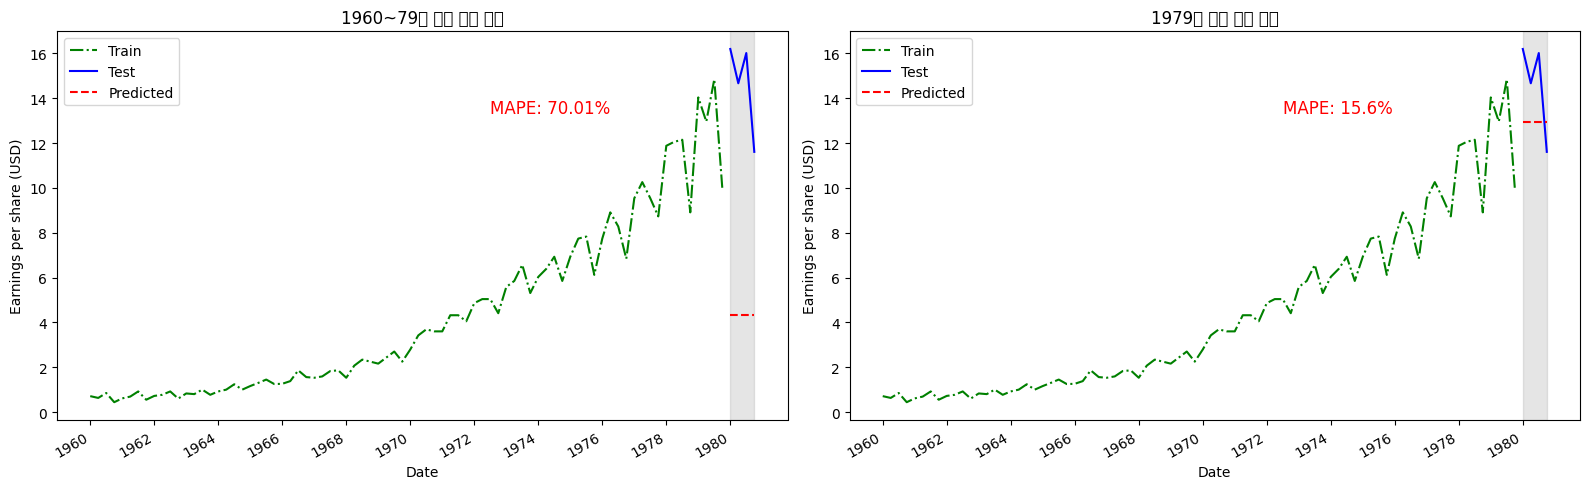

In [99]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot for 1960~79 mean model
ax[0].plot(train['date'], train['data'], 'g-.', label='Train')
ax[0].plot(test['date'], test['data'], 'b-', label='Test')
ax[0].plot(test['date'], test['preds_mean'], 'r--', label='Predicted')
ax[0].set_title('1960~79년 기반 평균 모델')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Earnings per share (USD)')
ax[0].axvspan(80, 83, color='#808080', alpha=0.2)
ax[0].legend(loc=2)
ax[0].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[0].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_hist_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[1].plot(train['date'], train['data'], 'g-.', label='Train')
ax[1].plot(test['date'], test['data'], 'b-', label='Test')
ax[1].plot(test['date'], test['1979preds'], 'r--', label='Predicted')
ax[1].set_title('1979년 기반 평균 모델')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Earnings per share (USD)')
ax[1].axvspan(80, 83, color='#808080', alpha=0.2)
ax[1].legend(loc=2)
ax[1].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[1].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_last_year, 2)}%", color='red', fontsize=12)

# Format date labels and save the figure
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('earnings_per_share_forecast.png')  # Save the figure

# 계절적 예측 구현
- 계절성이 있음은 확인되었다.
- 추가적인 패턴도 존재하는가?

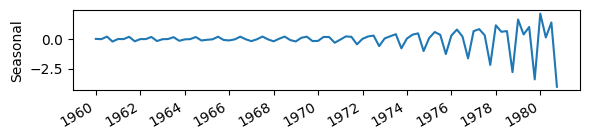

In [100]:
fig, ax = plt.subplots(figsize=(6, 1.5))

ax.plot(advanced_decomposition.seasonal)
ax.set_ylabel('Seasonal')
plt.xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

In [101]:
train['data'][-4:].values

array([14.04, 12.96, 14.85,  9.99])

In [102]:
test.loc[:, 'preds_seasonal'] = train['data'][-4:].values
mape_naive_seasonal = mape(test['data'], test['preds_seasonal'])
mape_naive_seasonal

<ipython-input-102-f3820593df2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'preds_seasonal'] = train['data'][-4:].values


11.561658552433654

In [103]:
test

,date,data,preds_mean,1979preds,preds_seasonal
80,1980-01-01,16.20,4.3085,12.96,14.04
81,1980-04-01,14.67,4.3085,12.96,12.96
82,1980-07-02,16.02,4.3085,12.96,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99


In [104]:
train

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
75,1978-10-01,8.91
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85


<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from current font.
  plt.tight_layout()
<ipython-input-105-a329062ad7cf>:41: UserWar

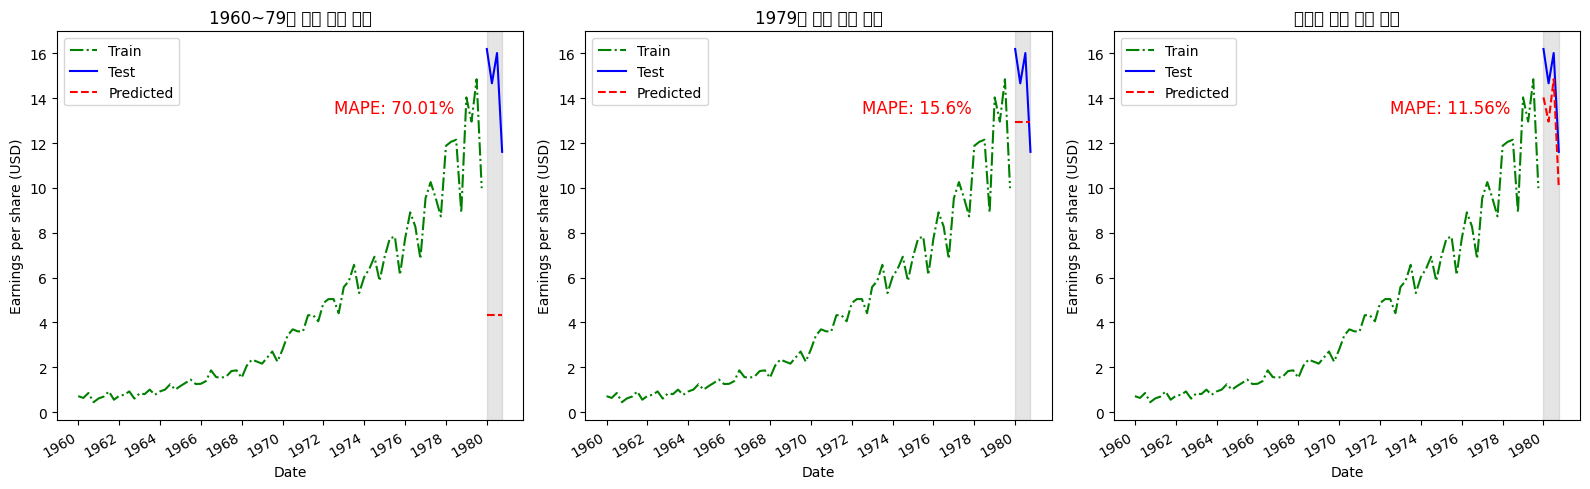

<Figure size 640x480 with 0 Axes>

In [105]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))

# Plot for 1960~79 mean model
ax[0].plot(train['date'], train['data'], 'g-.', label='Train')
ax[0].plot(test['date'], test['data'], 'b-', label='Test')
ax[0].plot(test['date'], test['preds_mean'], 'r--', label='Predicted')
ax[0].set_title('1960~79년 기반 평균 모델')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Earnings per share (USD)')
ax[0].axvspan(80, 83, color='#808080', alpha=0.2)
ax[0].legend(loc=2)
ax[0].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[0].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_hist_mean, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[1].plot(train['date'], train['data'], 'g-.', label='Train')
ax[1].plot(test['date'], test['data'], 'b-', label='Test')
ax[1].plot(test['date'], test['1979preds'], 'r--', label='Predicted')
ax[1].set_title('1979년 기반 평균 모델')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Earnings per share (USD)')
ax[1].axvspan(80, 83, color='#808080', alpha=0.2)
ax[1].legend(loc=2)
ax[1].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[1].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_last_year, 2)}%", color='red', fontsize=12)

# Plot for 1979 mean model
ax[2].plot(train['date'], train['data'], 'g-.', label='Train')
ax[2].plot(test['date'], test['data'], 'b-', label='Test')
ax[2].plot(test['date'], test['preds_seasonal'], 'r--', label='Predicted')
ax[2].set_title('계절적 요인 적용 모델')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Earnings per share (USD)')
ax[2].axvspan(80, 83, color='#808080', alpha=0.2)
ax[2].legend(loc=2)
ax[2].set_xticks(np.arange(0, 85, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax[2].text(50, max(train['data']) * 0.9, f"MAPE: {round(mape_naive_seasonal, 2)}%", color='red', fontsize=12)

# Format date labels and save the figure
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
plt.savefig('earnings_per_share_forecast.png')  # Save the figure

## 확률보행 확인
- 참조: 시계열 강의 입문

In [106]:
# 구글 주가 데이터임

df = pd.read_csv(DATA_PATH + 'GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


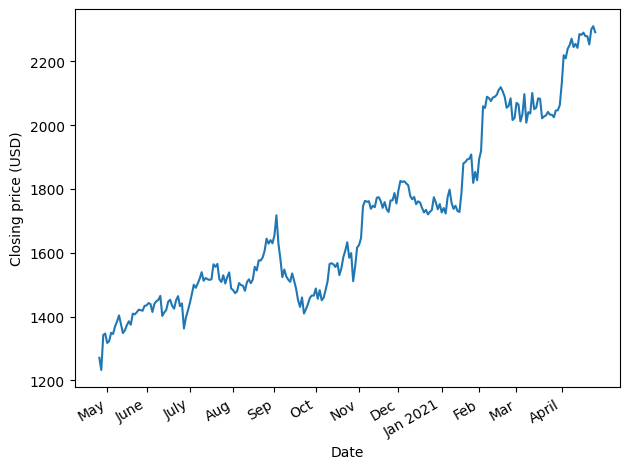

In [107]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235],
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

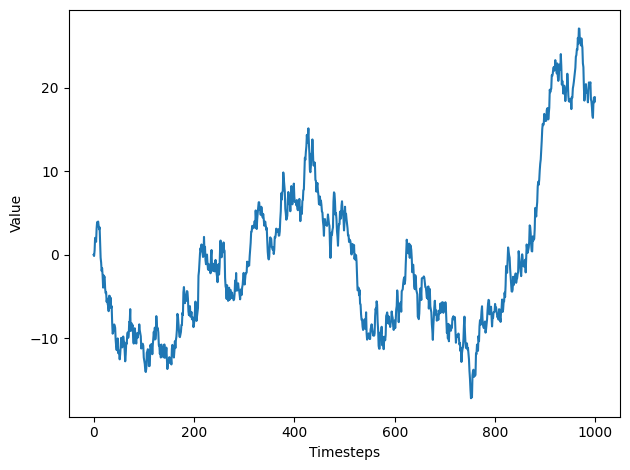

In [108]:
np.random.seed(42)

steps = np.random.standard_normal(1000)
steps[0]=0

random_walk = np.cumsum(steps)

fig, ax = plt.subplots()

ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

### 정상석 테스트 시각화
- 메서드를 만들어야 한다.

In [109]:
def simulate_process(is_stationary: bool) -> np.array:
    np.random.seed(42)
    process = np.empty(400)

    if is_stationary:
        alpha = 0.5
        process[0] = 0
    else:
        alpha = 1
        process[0] = 10

    for i in range(400):
        if i+1 < 400:
            process[i+1] = alpha*process[i] + np.random.standard_normal()
        else:
            break

    return process

In [110]:
stationary = simulate_process(True)
non_stationary = simulate_process(False)

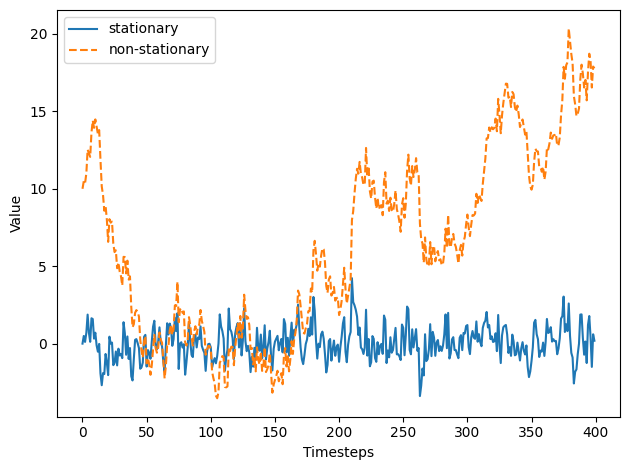

In [111]:
fig, ax = plt.subplots()

ax.plot(stationary, linestyle='-', label='stationary')
ax.plot(non_stationary, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

## 정상성의 조건

- 평균이 일정한가?
- 분산이 일정한가?
- 위 조건이 시점에 상관 없어야 한다!

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


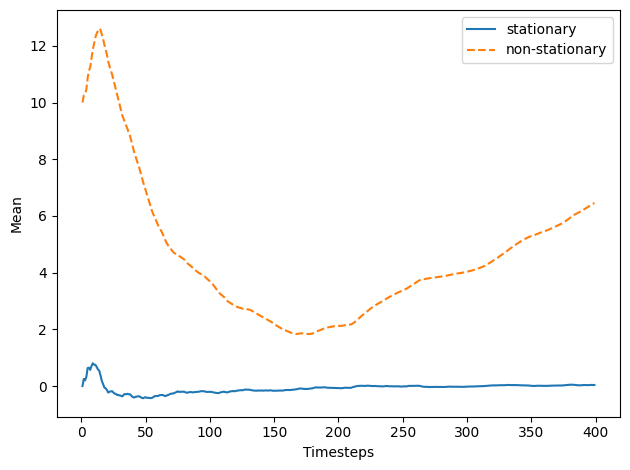

In [112]:
# 평균이 일정한가?

def mean_over_time(process: np.array) -> np.array:
    mean_func = []

    for i in range(len(process)):
        mean_func.append(np.mean(process[:i]))

    return mean_func

stationary_mean = mean_over_time(stationary)
non_stationary_mean = mean_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_mean, label='stationary')
ax.plot(non_stationary_mean, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Mean')
ax.legend(loc=1)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


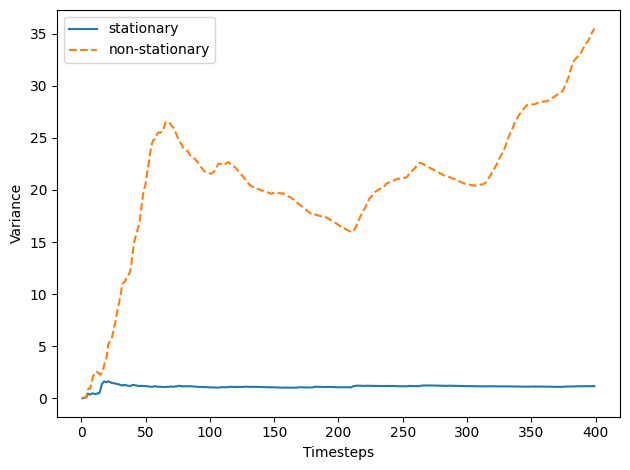

In [113]:
# 분산이 일정한가?

def var_over_time(process: np.array) -> np.array:
    var_func = []

    for i in range(len(process)):
        var_func.append(np.var(process[:i]))

    return var_func

stationary_var = var_over_time(stationary)
non_stationary_var = var_over_time(non_stationary)

fig, ax = plt.subplots()

ax.plot(stationary_var, label='stationary')
ax.plot(non_stationary_var, linestyle='--', label='non-stationary')
ax.set_xlabel('Timesteps')
ax.set_ylabel('Variance')
ax.legend(loc=2)

plt.tight_layout()
plt.show()

## 정상성 ADF 테스트

- 귀무가설: 시계열은 정상성이 아니다
- 대립가설: 시계열은 정상성을 따른다

In [114]:
random_walk #확률보행 시각화

array([  0.        ,  -0.1382643 ,   0.50942424,   2.03245409,
         1.79830072,   1.56416376,   3.14337658,   3.91081131,
         3.44133692,   3.98389696,   3.52047927,   3.05474952,
         3.29671179,   1.38343154,  -0.34148629,  -0.90377382,
        -1.91660494,  -1.6023576 ,  -2.51038168,  -3.92268538,
        -2.45703661,  -2.68281291,  -2.61528471,  -4.04003289,
        -4.58441562,  -4.47349303,  -5.62448661,  -5.24878859,
        -5.84942728,  -6.14112103,  -6.74282764,  -4.89054946,
        -4.90404668,  -5.96175761,  -5.1392127 ,  -6.36005635,
        -6.15119275,  -8.11086288,  -9.43904893,  -9.24218769,
        -8.50372111,  -8.33235283,  -8.44800111,  -8.74910481,
       -10.2276268 , -10.94747101, -11.40810978, -10.35098755,
       -10.00736926, -11.77040942, -11.44632545, -11.83140773,
       -12.50832973, -11.89665344, -10.86565392,  -9.9343738 ,
       -10.77359132, -11.0828037 , -10.75154026,  -9.77599514,
       -10.25516938, -10.44082835, -11.54716333, -12.74

In [115]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(random_walk)
ADF_result

#즉, 귀무가설이 기각되지 않았기에 현재 데이터는 정상성이 없다고 할 수 있다.

(-0.965952487691875,
 0.7654789696692581,
 0,
 999,
 {'1%': -3.4369127451400474,
  '5%': -2.864437475834273,
  '10%': -2.568312754566378},
 2735.41783678331)

## ACF 시각화
- 자기상관

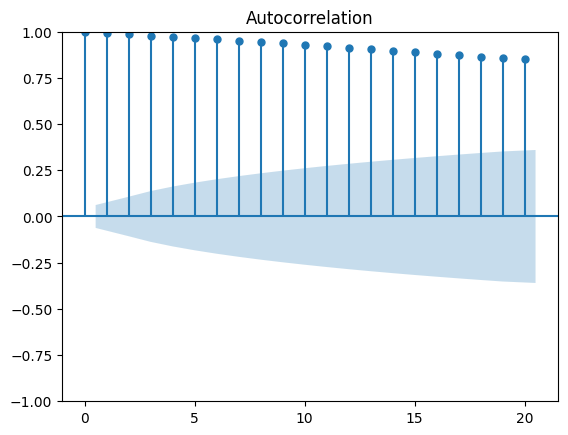

In [116]:
from statsmodels.graphics.tsaplots import plot_acf

# AutoCorrelaton Function
# 자기상관 : 특정 시점의 값이 이전 시점(이후 시점) 의 값과 상관관계를 가지는 현상

plot_acf(random_walk, lags = 20)
plt.show()

- 차분 적용

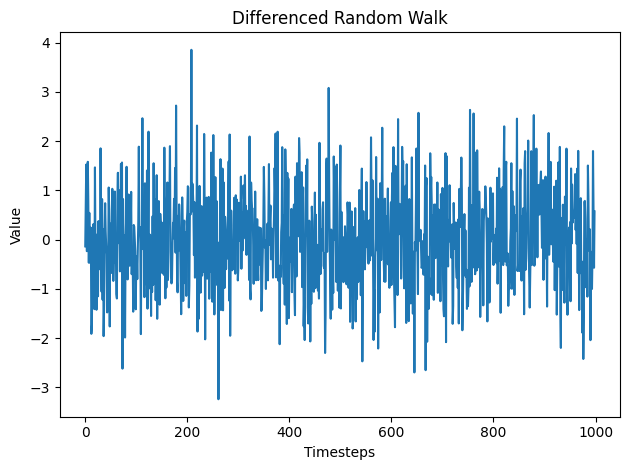

In [117]:
diff_random_walk = np.diff(random_walk)

plt.plot(diff_random_walk)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

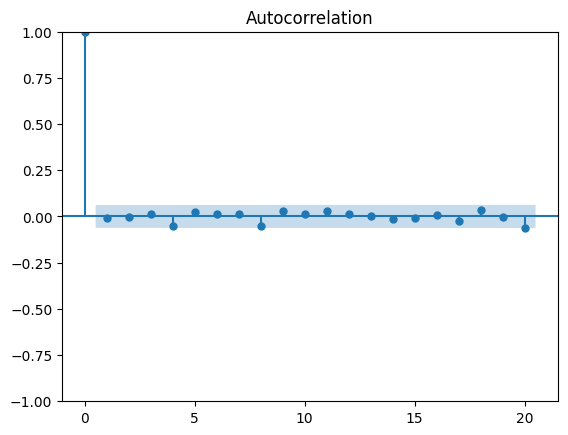

In [118]:
plot_acf(diff_random_walk, lags = 20)
plt.show()

## google 주식 데이터에 적용

통계량: 0.16025048664771302, p값: 0.9699419435913057
귀무가설이 채택된다. 시계열은 정상성이 아니다.


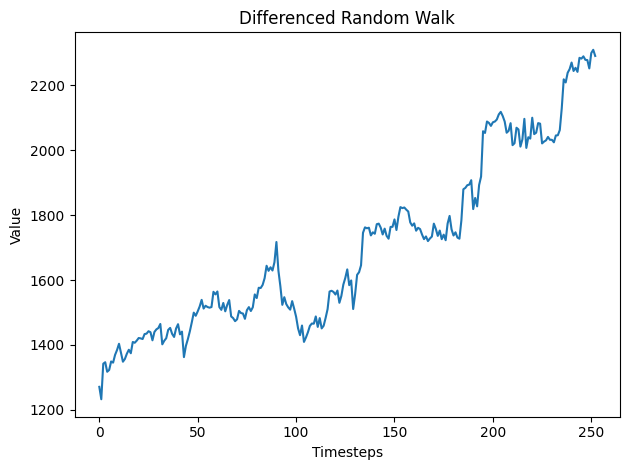

In [119]:
GOOGL_ADF_result = adfuller(df['Close'])
print(f'통계량: {GOOGL_ADF_result[0]}, p값: {GOOGL_ADF_result[1]}')
print('귀무가설이 채택된다. 시계열은 정상성이 아니다.')

plt.plot(df['Close'])
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

## 차분

통계량: -5.303439704295234, p값: 5.3865309614545585e-06
귀무가설이 채택되지 않는다. 시계열은 정상성을 따른다.


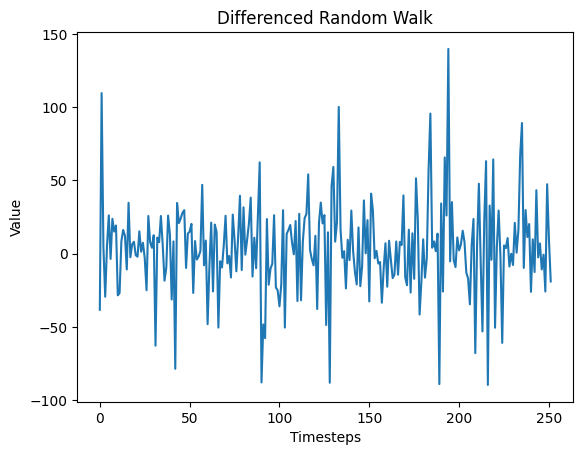

In [120]:
diff_close = np.diff(df['Close'], n = 1)

GOOGL_ADF_result = adfuller(diff_close)
print(f'통계량: {GOOGL_ADF_result[0]}, p값: {GOOGL_ADF_result[1]}')
print('귀무가설이 채택되지 않는다. 시계열은 정상성을 따른다.')

plt.plot(diff_close)
plt.title('Differenced Random Walk')
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.show()

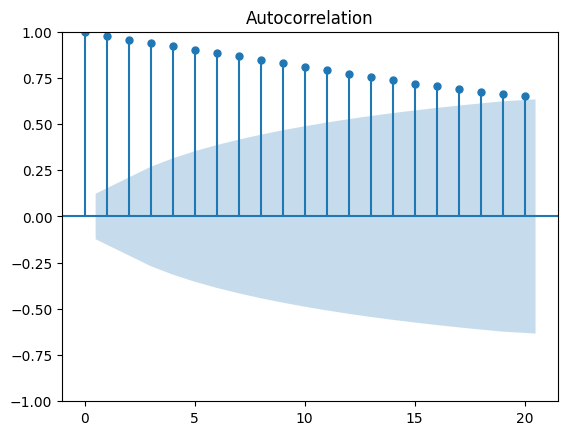

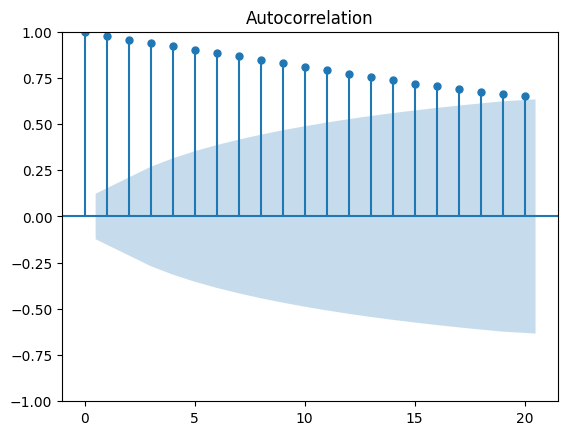

In [121]:
plot_acf(df['Close'], lags = 20)

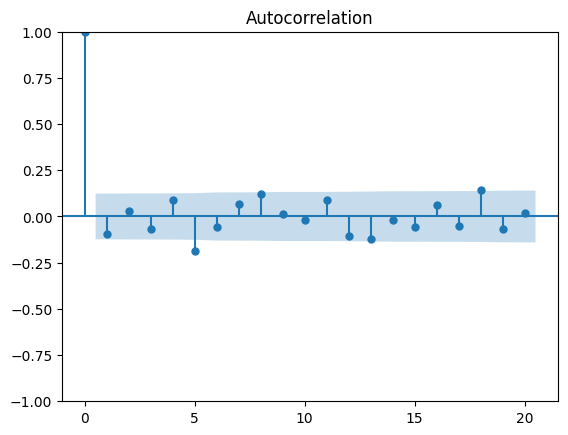

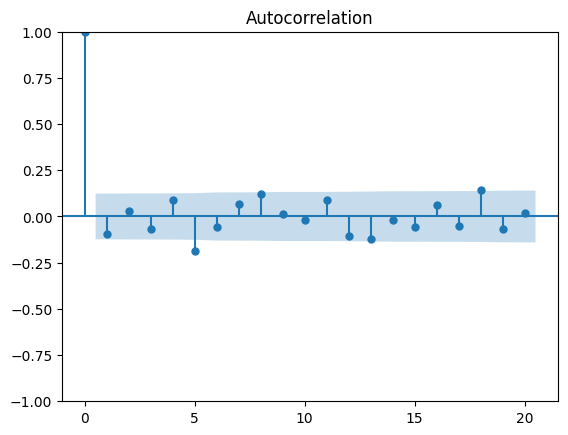

In [122]:
plot_acf(diff_close, lags = 20)

In [123]:
# MA 2모형으로 만든다.

## ACF 그래프 확인

- 지연 0일 때, 바로 상관계수 없으면

In [124]:
# 데이터 불러오기

df = pd.read_csv(DATA_PATH + 'widget_sales.csv')
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


### 시계열 데이터 시각화

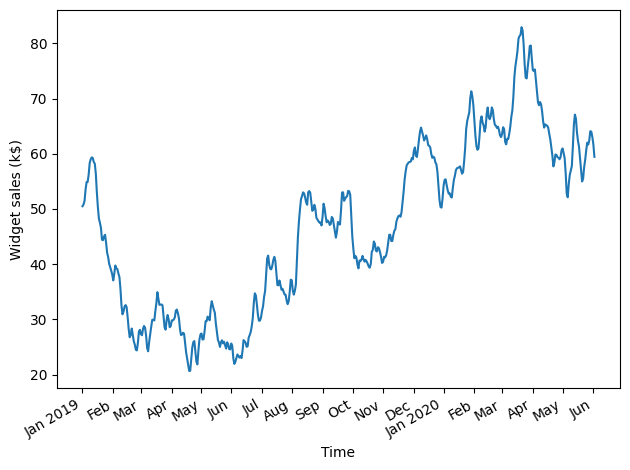

In [125]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [126]:
from statsmodels.tsa.stattools import adfuller

def checkADF(data):
	ADF_result = adfuller(data)
	print(f'통계량: {ADF_result[0]}, p-값: {ADF_result[1]}')

checkADF(df['widget_sales'])

통계량: -1.5121662069359048, p-값: 0.5274845352272605


In [127]:
# 차분 계산 방법
widget_sales_diff = np.diff(df['widget_sales'])
checkADF(widget_sales_diff)


통계량: -10.576657780341959, p-값: 7.076922818587193e-19


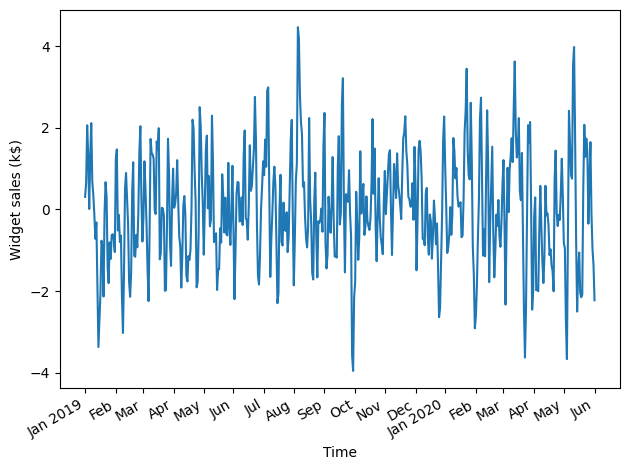

In [128]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [134]:
def difference_and_check(data_tmp, max_diff=5):
    """
    시계열 데이터가 정상적이지 않으면 차분하여 정상성 검정을 반복 수행하고
    ACF 도식화를 생성하는 함수.

    :param data: 시계열 데이터
    :param max_diff: 최대 차분 횟수
    :return: 차분 후 데이터 및 차분 횟수
    """
    diff_count = 0

    while diff_count < max_diff:
        # ADF 검정
        ADF_result = adfuller(data_tmp)
        p_value = ADF_result[1]

        print(f'차분 {diff_count}회 - ADF 통계량: {ADF_result[0]}, p-값: {p_value}')

        if p_value < 0.05:  # p-value가 0.05 미만이면 정상성을 만족
            print(f"차분 {diff_count}회: 데이터가 정상성을 만족합니다.")
            break

        # 차분 수행
        print(f"차분 {diff_count}회: 정상성 미만, 차분 후 다시 ADF 검정 수행")
        diff_count += 1
        data_tmp = data_tmp.diff().dropna()  # 한 번 차분

    # ACF 도식화
    plot_acf(data_tmp)
    plt.title(f'ACF after {diff_count} differencing')
    plt.show()

    return data_tmp, diff_count


차분 0회 - ADF 통계량: -1.5121662069359048, p-값: 0.5274845352272605
차분 0회: 정상성 미만, 차분 후 다시 ADF 검정 수행
차분 1회 - ADF 통계량: -10.576657780341959, p-값: 7.076922818587193e-19
차분 1회: 데이터가 정상성을 만족합니다.


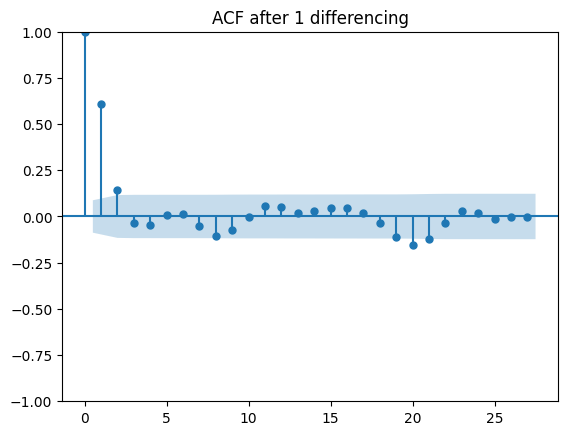

(1      0.308778
 2      0.672265
 3      2.064470
 4      1.330880
 5      0.012034
          ...   
 495    1.651336
 496   -0.095290
 497   -0.962187
 498   -1.358097
 499   -2.227958
 Name: widget_sales, Length: 499, dtype: float64,
 1)

In [135]:
difference_and_check(df['widget_sales'])

### 1차 결론
- MA(2) 모형을 만들어서 이동평균 예측

In [136]:
df_diff = pd.DataFrame({
    'widget_sales_diff': widget_sales_diff
})
df_diff

,widget_sales_diff
0,0.308778
1,0.672265
2,2.064470
3,1.330880
4,0.012034
...,...
494,1.651336
495,-0.095290
496,-0.962187
497,-1.358097


In [137]:
# 훈련 및 테스트 데이터 분리

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


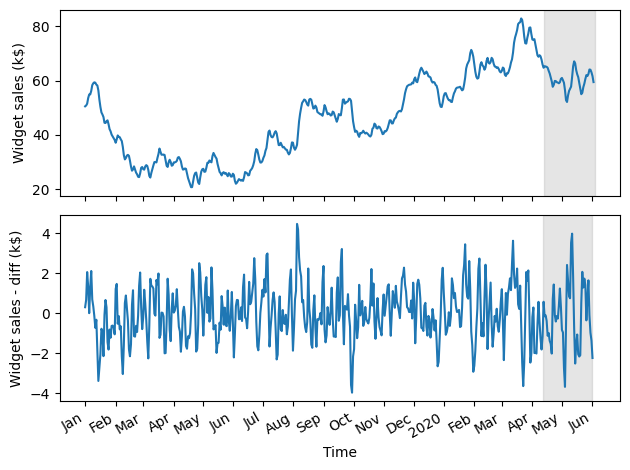

In [138]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Rolling Forecast
- 롤링 예측을 적용한 함수 구현
- 거의 모든 시계열 예측 문제를 풀 때 핵심 키워드로 작용할 수 있음



## SARIMA
- ARIMA가 아니라?
- 테무에서 산 아리마

In [139]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    """
    롤링 윈도우 방법으로 시계열 데이터를 예측하는 함수.

    매개변수:
    - df (pd.DataFrame): 입력 시계열 데이터.
    - train_len (int): 학습 데이터의 길이 (초기 학습 구간 크기).
    - horizon (int): 예측할 데이터의 기간 (총 예측 기간).
    - window (int): 롤링 윈도우 크기.
    - method (str): 예측 방법 ('mean', 'last', 'MA' 중 하나 선택).

    반환값:
    - list: 예측된 값의 리스트.
    """

    # 학습 기간과 예측 기간을 합친 전체 길이
    total_len = train_len + horizon

    # 'mean' 방법: 이전 데이터의 평균값을 예측 값으로 사용
    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # 현재 윈도우 이전까지의 평균 계산
            mean = np.mean(df[:i].values)
            # 계산된 평균값을 현재 윈도우 크기만큼 예측값 리스트에 추가
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    # 'last' 방법: 이전 데이터의 마지막 값을 예측 값으로 사용
    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # 현재 윈도우 이전까지의 마지막 값 가져오기
            last_value = df[:i].iloc[-1].values[0]
            # 가져온 마지막 값을 현재 윈도우 크기만큼 예측값 리스트에 추가
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    # 'MA' 방법: 이동평균(MA) 모델을 사용해 예측
    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):  # 윈도우 단위로 반복
            # SARIMAX 모델 설정: (0,0,2)은 MA(2) 모델을 의미
            model = SARIMAX(df[:i], order=(0, 0, 2))
            # SARIMAX 모델 학습
            res = model.fit(disp=False)
            # 학습된 모델로 예측 수행
            predictions = res.get_prediction(0, i + window - 1)
            # 예측값 중 마지막 윈도우에 해당하는 값들 가져오기
            oos_pred = predictions.predicted_mean.iloc[-window:]
            # 예측값을 결과 리스트에 추가
            pred_MA.extend(oos_pred)

        return pred_MA

In [140]:
# 테스트

pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


## 훈련 데이터 도식화

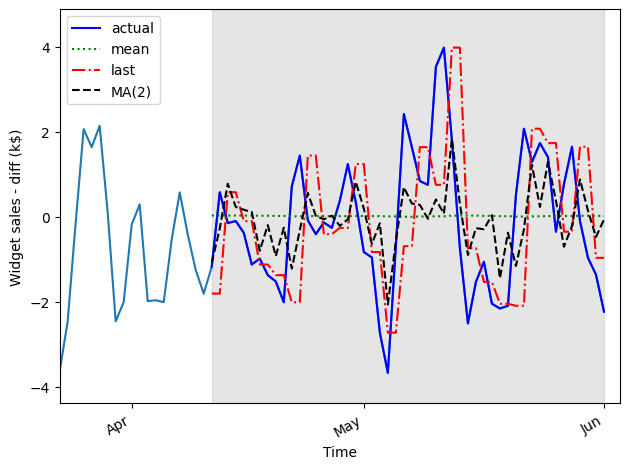

In [141]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498],
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 모형 평가

In [143]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.948171449776926


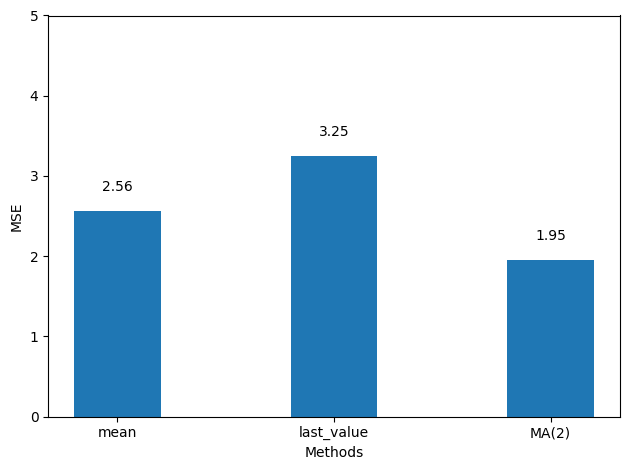

In [144]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()
plt.show()

# 역변환

In [145]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

<ipython-input-145-4e30989af2f9>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()
<ipython-input-145-4e30989af2f9>:2: SettingWithCopyWarning: 
A value

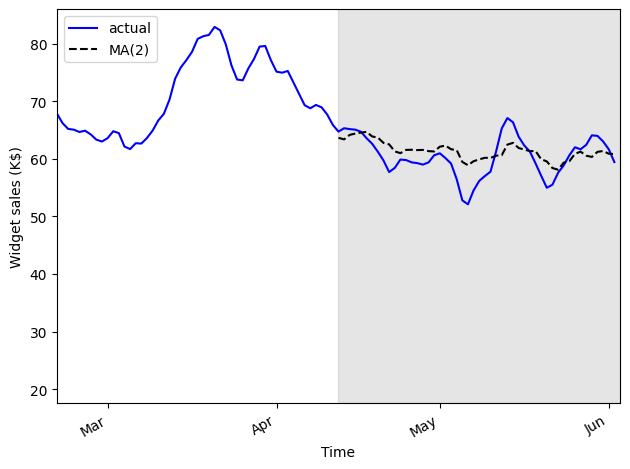

In [146]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498],
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()